# Intellligent Data Analysis

- **Data Set:** #31
- **Author 1:** Juraj Baráth
- **Author 2:** Vladimír Svitok

## Strojové učenie (max. 15b)

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania. Na to sa využívajú techniky strojového učenia. V tomto projekte sa zameriame na rozhodovacie stromy vzhľadom na ich jednoduchú interpretovateľnosť.

V tejto fáze dostanete nový dataset, na ktorom oddemonštrujete znovupoužiteľnosť vami realizovaného predspracovania. Vami natrénované klasifikátory budú porovnané medzi sebou; uvidíte tak, ako dobre ste sa umiestnili v rámci vášho cvičenia, resp. celého predmetu.

V poslednej fáze sa od vás očakáva:
- **Predspracovanie nového datasetu vami realizovaným postupom predspracovania a opis prípadných zmien (2b).** Spustite postup predspracovania realizovaný v predchádzajúcej fáze nad novým datasetom. Nový dataset bude mať rovnakú štruktúru ako váš pôvodný, nebudú sa v ňom však možno nachádzať niektoré problémy (nové vám nepribudnú). Ak si spustenie predspracovania vyžiada zmeny v kóde, opíšte ich.
- **Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu (3b).** Vyskúšajte jednoduché pravidlá zahŕňajúce jeden atribút, ale aj komplikovanejšie zahŕňajúce viacero atribútov (ich kombinácie). Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Pravidlá (manuálne vytvorené klasifikátory) vyhodnoťte pomocou metrík správnosť (angl. *accuracy*), presnosť (angl. *precision*) a úplnosť (angl. *recall*). 
- **Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov (4b).** Na trénovanie využite algoritmus dostupný v knižnici `scikit-learn` (`CART`). Vizualizujte natrénované pravidlá. Vyhodnoťte natrénovaný rozhodovací strom pomocou metrík správnosť (angl. *accuracy*), presnosť (angl. *precision*) a úplnosť (angl. *recall*). Porovnajte natrénovaný klasifikátor s vašimi manuálne vytvorenými pravidlami z druhého kroku. 
- **Optimalizácia hyperparametrov (4b).** Preskúmajte hyperparametre klasifikačného algoritmu `CART` a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali preučenie. Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite 10-násobnú krížovú validáciu na trénovacej množine.
- **Vyhodnotenie vplyvu zvolenej stratégie riešenia chýbajúcich hodnôt na správnosť klasifikácie (2b).** Zistite, či použitie zvolených stratégií riešenia chýbajúcich hodnôt vplýva na správnosť (angl. accuracy) klasifikácie. Ktorá stratégia sa ukázala ako vhodnejšia pre daný problém?

Správa sa odovzdáva v 12. týždni semestra na cvičení (dvojica svojmu cvičiacemu odprezentuje výsledky strojového učenia v `Jupyter Notebooku`). Následne správu elektronicky odovzdá jeden člen z  dvojice do systému AIS do **nedele 15.12.2019 do 23:59**.


In [1]:
# Automatically reformat python code
# Check https://medium.com/openplanetary/code-formatting-in-jupyter-cells-8fee4eda072f for more info
# %load_ext lab_black

# Data analysis and debugging helper methods

In [2]:
"""
    Checks the not availability of a value
"""


def is_nan(v):
    sv = str(v)
    return sv == "?" or sv == "NaN" or sv == "nan"

In [3]:
"""
    Prints the possible values of columns having less than 50 possible values
    For columns having numeric values prints the min, 5% percentile, 95% percentile, max, mean, median
"""


def print_col_values(d):

    """ Formats a number by converting floats to 4 decimals and keeps integers"""

    def format_num(num):
        num = round(num, 4)
        return int(num) if num == int(num) else num

    cols = list(d.columns)
    cols.sort()

    for c in cols:
        if str(d.iloc[0][c]).replace(".", "").isdigit():
            v = d[c].apply(
                lambda n: float(n) if str(n).replace(".", "").isdigit() else np.nan
            )
            print(
                "••► " + c + ": min = {}, 5% = {}, 95% = {}, max = {},"
                " mean = {}, median = {}".format(
                    format_num(v.min()),
                    format_num(np.nanpercentile(v, 5)),
                    format_num(np.nanpercentile(v, 95)),
                    format_num(v.max()),
                    format_num(v.mean()),
                    format_num(v.median()),
                ),
                end="\n\n",
            )
        else:
            l = list(d.drop_duplicates(c)[c])
            if len(l) < 50:
                print("••► " + c + " (" + str(len(l)) + "): " + str(l), end="\n\n")
            else:
                print("••► " + c + " (" + str(len(l)) + ")", end="\n\n")

In [4]:
"""
    Prints the statistics of both personal and other train data at a certain stage
"""


def print_data_stats(stage, data, data2):
    print(
        "=========================="
        + stage
        + " ======================"
    )
    print("===== Data =====")
    print_col_values(data)
    print("==== Data 2 =====")
    print_col_values(data2)

In [5]:
"""
    Draws a chart of a column in the data set with the given label
"""


def draw_chart(label, data, column):
    data.plot.scatter(label=label, x="id", y=column, figsize=(15, 5)).plot()

In [6]:
"""
    Draws charts of the medical metrics data against the class with the given titles in the given data sets
"""


def draw_md_charts(titles, data_array):
    for gl in [
        "skewness_glucose",
        "mean_glucose",
        "kurtosis_glucose",
        "std_glucose",
        "mean_oxygen",
        "std_oxygen",
        "kurtosis_oxygen",
        "skewness_oxygen",
    ]:
        for cl in range(2):
            for i in range(len(data_array)):
                d_source = data_array[i]
                d = d_source[d_source["class"] == cl]
                draw_chart(titles[i] + " - " + gl + " - Class " + str(cl), d, gl)

# Data transformations

In [7]:
"""
    Renames the Unnamed: 0 column to id
"""


def rename_id_column(data, data2, debug):
    data.rename(columns={data.columns[0]: "id"}, inplace=True)
    data2.rename(columns={data2.columns[0]: "id"}, inplace=True)
    return data, data2

In [8]:
""" 
    Extracts the 4 columns of the medical info from data2 and puts them as new columns, removes the old column
"""


def extract_medical_info(data, data2, debug):
    # Generate the list of columns we need to extract from medical_info
    mi_cols = list(dict(eval(data2["medical_info"][0])).keys())
    # Extract the 4 data included in the medical_info column and put it to 4 separate columns
    for c in mi_cols:
        data2[c] = data2["medical_info"].apply(
            lambda d: 0.0 if str(d) == "nan" else float(dict(eval(str(d)))[c])
        )
    data2.drop(columns="medical_info", inplace=True)
    return data, data2

In [9]:
""" 
    Removes the time from the date_of_birth and replaces "/" characters to "-" characters in it
"""


def fix_date_of_birth(data, data2, debug):
    # Remove time from the date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.split(" ", expand=True)[0]

    # Replace '/' characters to '-' characters in date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.replace("/", "-")
    return data, data2

In [10]:
"""
    Replace non numeric age values with 0
"""


def fix_non_numeric_age_values(data, data2, debug):
    data["age"] = data["age"].apply(
        lambda age: int(age) if str(age).replace(".", "", 1).isdigit() else 0
    )
    return data, data2

In [11]:
"""
    Fix the date format in the date_of_birth, make it consistently being yyyy-mm-dd
"""


def fix_date_format(data, data2, debug):
    def fix_date(date):
        s = date.split("-")
        if (
            len(s[0]) == 4
        ):  # Don't need to fix anything if the first field is a 4 digit year number
            return date
        if len(s[2]) == 4:  # Replace dd-mm-yyyy format to yyyy-mm-dd format
            return s[2] + "-" + s[1] + "-" + s[0]

        # Replace yy-mm-dd format to yyyy-mm-dd format
        #
        # If the last 2 digit of the 4 digit year field is bigger than 20,
        # then we expect a date of birth between 1921 and 1999, otherwise between 2000 and 2020,
        # because we have verified earlier that we don't have people older than 90 years old in such date format
        if int(s[0]) > 20:
            return "19" + s[0] + "-" + s[1] + "-" + s[2]
        else:
            return "20" + s[0] + "-" + s[1] + "-" + s[2]

        return date

    data["date_of_birth"] = data["date_of_birth"].apply(fix_date)
    return data, data2

In [12]:
"""
    Calculate the missing ages of people based on the dataset date
"""


def calc_missing_ages_from_date_of_birth(data, data2, debug):
    # Approximate the date of the dataset by adding the age of people to their date_of_birth. Choose the highest value.
    def add_age(row):
        return (
            str(int(row["date_of_birth"][:4]) + row["age"]) + row["date_of_birth"][4:]
        )

    # Fixes the age based on the previously calculated dataset age
    def fix_age(row):
        if row["age"] == 0:
            birth = [int(i) for i in row["date_of_birth"].split("-")]
            dif = [ds_date[0] - birth[0], ds_date[1] - birth[1], ds_date[2] - birth[2]]
            if debug:
                print(ds_date, "-", birth, "=", dif, end=" --> age = ")
            if dif[2] < 0:
                dif[1] -= 1
            if dif[1] < 0:
                dif[0] -= 1
            if debug:
                print(dif[0])
            return dif[0]
        return row["age"]

    ds_date = [int(i) for i in data.apply(add_age, axis=1).max().split("-")]
    if debug:
        print("Data set age:", ds_date)

    data["age"] = data.apply(lambda row: fix_age(row), axis=1)
    return data, data2

In [13]:
"""
    Trim all the leading spaces from every String data
"""


def trim_leading_spaces(data, data2, debug):
    for d in (data, data2):
        for c in d.columns:
            d[c] = d[c].apply(lambda s: s if type(s) != str else s.strip())
    return data, data2

In [14]:
"""
    Merge duplicate rows by choosing the average of every available data,
    for non numeric data using the first available match.

    If one of the numeric value is 0, while a none zero value exist, ignore the zero value
"""


def merge_duplicate_rows(data, data2, debug):
    if debug:
        print("Detecting duplicates based on names...")

    duplicate_names = list(data2[data2.duplicated(["name"])]["name"])
    if debug:
        print("Found", len(duplicate_names), "duplicates, merging them...")

    fixed_rows = []

    for name in duplicate_names:
        rows = data2[data2["name"] == name]
        l = len(rows)
        if debug:
            print("\nMerging", l, "rows of name " + name + "...")
        bestRow = rows.iloc[0].copy()
        for c in data2.columns:
            if c == "id":  # Do not merge the id column
                continue
            if debug:
                print(c, list(rows[c]), end=" --> ")
            m = 1
            for i in range(1, l):
                row = rows.iloc[i]
                if is_nan(row[c]):
                    continue
                if is_nan(bestRow[c]):
                    bestRow[c] = row[c]
                    m = 1
                elif (type(row[c]) != str) and row[c] != 0 and row[c] != 0.0:
                    bestRow[c] += row[c]
                    if bestRow[c] != row[c]:
                        m += 1
            if type(bestRow[c]) != str and m > 0:
                bestRow[c] /= m
            if debug:
                print([bestRow[c]], end="\n")
        fixed_rows.append(bestRow)

    if debug:
        print("Applying changes...")

    data2.drop_duplicates(subset=["name"], keep=False, inplace=True)
    for r in fixed_rows:
        data2 = data2.append(r)
    return data, data2

In [15]:
"""
    Fixes the pregnant column values, keeps nan rows, changes others to 1 
    if they start with t (case insensitive), changes them to 0 otherwise
"""


def fix_pregnant(data, data2, debug):
    data2["pregnant"] = data2["pregnant"].apply(
        lambda p: np.nan if str(p) == "nan" else int(p[0].lower() == "t")
    )
    return data, data2

In [16]:
"""
    Replaces missing data with median values for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_medians(data2, rdata2, debug):
    if debug:
        print("Filling missing data with median values...")
    for c in data2.columns:
        med = (
            data2[c].value_counts().idxmax()
            if type(data2.iloc[0][c]) == str
            else data2[c].median()
        )
        if debug:
            print(c, "-->", med)
        data2[c] = data2[c].apply(lambda v: med if is_nan(v) else v)  
        rdata2[c] = rdata2[c].apply(lambda v: med if is_nan(v) else v)
    return data2, rdata2

In [17]:
"""
    Replaces missing data with linear regression for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_regr(data2, rdata2, debug):
    if debug:
        print("Filling missing data with linear regression values...")
    model1 = LinearRegression()
    model2 = LinearRegression()
    modeldata = data2[data2[['mean_glucose','std_glucose']].notnull().all(axis=1)]
    x = np.array(modeldata['mean_glucose']).reshape(-1,1)
    y = np.array(modeldata['std_glucose']).reshape(-1,1)
    model1.fit(x, y)
    model2.fit(y, x)
    data2['mean_glucose'] = data2.apply(lambda row: (
        row['mean_glucose'] if not is_nan(row['mean_glucose']) else (model2.intercept_ + model2.coef_ * row['std_glucose'])[0][0] if not is_nan(row['std_glucose']) else np.nan
    ), axis=1)
    data2['std_glucose'] = data2.apply(lambda row: (
        row['std_glucose'] if not is_nan(row['std_glucose']) else (model1.intercept_ + model1.coef_ * row['mean_glucose'])[0][0] if not is_nan(row['mean_glucose']) else np.nan
    ), axis=1)
    rdata2['mean_glucose'] = rdata2.apply(lambda row: (
        row['mean_glucose'] if not is_nan(row['mean_glucose']) else (model2.intercept_ + model2.coef_ * row['std_glucose'])[0][0] if not is_nan(row['std_glucose']) else np.nan
    ), axis=1)
    rdata2['std_glucose'] = rdata2.apply(lambda row: (
        row['std_glucose'] if not is_nan(row['std_glucose']) else (model1.intercept_ + model1.coef_ * row['mean_glucose'])[0][0] if not is_nan(row['mean_glucose']) else np.nan
    ), axis=1)
    return data2, rdata2

In [18]:
"""
    Replaces outlying values in every numeric column the following way:
    --> Applies 90% percentil for values >90% percentil * 2 of the data set
    --> Applies 10% percentil for values <10% percentil * 0.5 of the data set
"""


def replace_outlying_0595(data2, rdata2, debug):
    for c in data2.columns:
        if type(data2.iloc[0][c]) == str or len(list(data2.drop_duplicates(c)[c])) <= 10:
            continue
        pct10 = np.nanpercentile(data2[c], 10)
        pct90 = np.nanpercentile(data2[c], 90)
        data2[c] = data2[c].apply(
            lambda d: pct90 if d > pct90 * 2 else pct10 if d < pct10 * 0.5 else d
        )
        rdata2[c] = rdata2[c].apply(
            lambda d: pct90 if d > pct90 * 2 else pct10 if d < pct10 * 0.5 else d
        )

    return data2, rdata2

# Invokers of the data transformations

In [19]:
"""
    Transforms the train data into a usable trainable form
"""


def fix_data(data, data2, rdata, rdata2, debug):

    data, data2 = rename_id_column(data, data2, debug)
    data, data2 = extract_medical_info(data, data2, debug)
    data, data2 = fix_date_of_birth(data, data2, debug)
    data, data2 = fix_non_numeric_age_values(data, data2, debug)
    data, data2 = fix_date_format(data, data2, debug)
    data, data2 = calc_missing_ages_from_date_of_birth(data, data2, debug)
    data, data2 = trim_leading_spaces(data, data2, debug)
    data, data2 = merge_duplicate_rows(data, data2, debug)
    data, data2 = fix_pregnant(data, data2, debug)
    
    rdata, rdata2 = rename_id_column(rdata, rdata2, debug)
    rdata, rdata2 = extract_medical_info(rdata, rdata2, debug)
    rdata, rdata2 = fix_date_of_birth(rdata, rdata2, debug)
    rdata, rdata2 = fix_non_numeric_age_values(rdata, rdata2, debug)
    rdata, rdata2 = fix_date_format(rdata, rdata2, debug)
    rdata, rdata2 = calc_missing_ages_from_date_of_birth(rdata, rdata2, debug)
    rdata, rdata2 = trim_leading_spaces(rdata, rdata2, debug)
    rdata, rdata2 = merge_duplicate_rows(rdata, rdata2, debug)
    rdata, rdata2 = fix_pregnant(rdata, rdata2, debug)
    
    data2, rdata2 = replace_missing_data_with_regr(data2, rdata2, debug)
    data2, rdata2 = replace_missing_data_with_medians(data2, rdata2, debug)
    data2, rdata2 = replace_outlying_0595(data2, rdata2, debug)
    return pd.merge(data, data2, on = ['name','address']), pd.merge(rdata, rdata2, on = ['name','address'])

# Here starts the actual program

In [20]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from sklearn.linear_model import LinearRegression
import json
import seaborn as sns

In [21]:
# Read train data
data = pd.read_csv("personal_train.csv")
data2 = pd.read_csv("other_train.csv")

In [22]:
# Read real data
rdata = pd.read_csv("personal_valid.csv")
rdata2 = pd.read_csv("other_valid.csv")

In [23]:
# Print train data before fix
print_data_stats("BEFORE FIX - TRAIN", data, data2)

==========================BEFORE FIX - TRAIN ======================
===== Data =====
••► Unnamed: 0: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean = 1966, median = 1966

••► address (3933)

••► age: min = 3, 5% = 32, 95% = 70, max = 99, mean = 51.8638, median = 52

••► date_of_birth (3706)

••► name (3933)

••► sex (2): [' Male', ' Female']

==== Data 2 =====
••► Unnamed: 0: min = 0, 5% = 199.1, 95% = 3782.9, max = 3982, mean = 1991, median = 1991

••► address (3933)

••► capital-gain: min = 0, 5% = 0, 95% = 4697.95, max = 99999, mean = 1021.0453, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 4356, mean = 89.8525, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2559, median = 0

••► education (17): [' Assoc-acdm', ' HS-grad', ' Some-college', ' Bachelors', ' Assoc-voc', ' 10th', ' Doctorate', ' 5th-6th', ' Masters', ' 12th', ' 9th', ' 11th', ' 7th-8th', nan, ' Prof-school', ' 1st-4th', ' Preschool']

••► education-num: min = 1, 5% = 5, 95% = 14,

In [24]:
# Print real data before fix
print_data_stats("BEFORE FIX - REAL", rdata, rdata2)

==========================BEFORE FIX - REAL ======================
===== Data =====
••► Unnamed: 0: min = 0, 5% = 65.5, 95% = 1244.5, max = 1310, mean = 655, median = 655

••► address (1311)

••► age: min = 15, 5% = 32, 95% = 71, max = 98, mean = 51.9983, median = 52

••► date_of_birth (1289)

••► name (1311)

••► sex (2): [' Female', ' Male']

==== Data 2 =====
••► Unnamed: 0: min = 0, 5% = 68, 95% = 1292, max = 1360, mean = 680, median = 680

••► address (1311)

••► capital-gain: min = 0, 5% = 0, 95% = 4646.65, max = 99999, mean = 886.2723, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 2547, mean = 81.8586, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2628, median = 0

••► education (17): [' HS-grad', ' Some-college', ' Bachelors', ' Masters', ' Prof-school', ' 12th', ' Assoc-acdm', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 5th-6th', ' Assoc-voc', ' Doctorate', nan, ' 1st-4th', ' Preschool']

••► education-num: min = 1, 5% = 6, 95% = 14, max = 16, 

### Print the first 50 lines of each data we have

In [25]:
data.head(50)

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",60,Male,1959-09-26
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",52,Male,1966-10-28
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",60,Male,1959-06-16
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",39,Male,1980-09-09
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",49,Male,1970-02-22
5,5,Ronald Lange,"30973 Martinez Shores\r\nJameston, CA 70245",46,Male,1973-09-25
6,6,Boyd Eiselein,29941 Christopher Curve Apt. 682\r\nRaychester...,54,Female,1964-10-31
7,7,Raymond Smith,53487 Scott Extensions Apt. 824\r\nMccartytown...,67,Male,1952-07-23
8,8,Harold Miller,"8514 Elizabeth Crescent\r\nWest Joseland, GA 4...",52,Male,1967-06-28
9,9,Charles Czachorowski,"6798 Wagner Locks Suite 377\r\nLake Brenda, DC...",30,Male,1988-11-07


In [26]:
data2.head(50)

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,...,education,fnlwgt,class,std_glucose,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,0,Mike Riley,023 Joseph Estate Suite 799\r\nLake Andrewvill...,White,Married-civ-spouse,Prof-specialty,f,12.0,Husband,1.605420,...,Assoc-acdm,251396.0,0.0,37.450318,>50K,"{'mean_oxygen':'10.03511706','std_oxygen':'35....",Canada,45.0,0.0,Local-gov
1,1,Earl Hoffmann,"700 Darlene Mill\r\nJackburgh, GA 99369",White,Divorced,Craft-repair,f,9.0,Unmarried,10.994893,...,HS-grad,157446.0,1.0,33.842927,<=50K,"{'mean_oxygen':'7.834448161','std_oxygen':'33....",United-States,45.0,0.0,Private
2,2,Lorenzo Mann,"56863 Stephen Island\r\nSouth Danielle, NV 40760",White,Divorced,Craft-repair,t,10.0,Not-in-family,-0.290893,...,Some-college,106014.0,0.0,51.123164,<=50K,"{'mean_oxygen':'3.505852843','std_oxygen':'19....",United-States,60.0,0.0,Private
3,3,Justin Trevino,"18446 Pace Junction\r\nNew Christyfurt, SD 32280",White,Never-married,Tech-support,f,13.0,Not-in-family,13.476089,...,Bachelors,189590.0,1.0,45.923142,<=50K,"{'mean_oxygen':'83.55351171','std_oxygen':'66....",United-States,40.0,0.0,Private
4,4,Thomas Davis,"67753 Wilson Ford\r\nNew Rachelport, NV 50148",White,Married-civ-spouse,Transport-moving,f,9.0,Husband,0.680234,...,HS-grad,134768.0,0.0,46.867134,>50K,"{'mean_oxygen':'2.602842809','std_oxygen':'18....",United-States,40.0,0.0,Private
5,5,Lynn Quist,"2232 Flores Ridge\r\nSanchezstad, IL 31455",White,Divorced,Transport-moving,f,9.0,Not-in-family,1.315007,...,HS-grad,143542.0,0.0,40.466252,<=50K,"{'mean_oxygen':'4.886287625','std_oxygen':'24....",United-States,40.0,0.0,Private
6,6,Roscoe Shelton,"6954 Carrillo Shoals Apt. 139\r\nSandersview, ...",White,Married-civ-spouse,Adm-clerical,f,13.0,Husband,2.731511,...,Bachelors,259840.0,0.0,35.750382,<=50K,"{'mean_oxygen':'1.705685619','std_oxygen':'17....",United-States,45.0,0.0,Private
7,7,Jose Aigner,"76756 Ashley Mount\r\nGomezchester, NV 49283",White,Divorced,Sales,f,13.0,Not-in-family,2.022478,...,Bachelors,364548.0,0.0,39.279398,>50K,"{'mean_oxygen':'2.117056856','std_oxygen':'15....",United-States,40.0,0.0,Private
8,8,Robert Gerke,"820 Mark Drives\r\nMichaelchester, OH 64396",White,Married-civ-spouse,Sales,F,10.0,Husband,0.169639,...,Some-college,114520.0,0.0,49.502052,<=50K,"{'mean_oxygen':'5.197324415','std_oxygen':'26....",United-States,40.0,0.0,Self-emp-not-inc
9,9,Andre Bennett,"25878 Hector Canyon\r\nJerryfurt, AZ 38098",White,Never-married,Prof-specialty,f,11.0,Not-in-family,0.743007,...,Assoc-voc,436770.0,0.0,40.479149,<=50K,"{'mean_oxygen':'0.766722408','std_oxygen':'9.5...",United-States,40.0,0.0,Private


In [27]:
rdata.head(50)

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Philip Miller,"7910 Rosales Plain Apt. 454\r\nPort Carl, GA 6...",62,Female,1956-12-09 00:00:00
1,1,Mitch Wilson,055 Morgan Plains Suite 225\r\nEast Darrylmout...,38,Male,80-10-30
2,2,James Olsen,"PSC 7359, Box 2088\r\nAPO AE 62717",34,Female,1985-10-19
3,3,Maurice Riley,USS Allen\r\nFPO AP 87677,39,Female,1980-06-08
4,4,Larry Stanley,"491 Fields Key Suite 544\r\nGracestad, MT 13456",67,Female,18/05/1952
5,5,Stanley Orndorff,"1989 Dylan Inlet Apt. 862\r\nCoreystad, MA 30654",56,Male,1962-12-06
6,6,Mark Bierlein,Unit 7145 Box 9167\r\nDPO AA 86245,57,Male,1962-08-10 00:00:00
7,7,Matthew Spence,741 Alvarez Village Suite 345\r\nNew Stephanie...,75,Female,1944-10-27
8,8,Willie Williams,"149 Parker Tunnel\r\nRyanside, VA 94814",41,Male,78-04-21
9,9,Curtis Johnson,08244 Burton Junctions Suite 409\r\nScottmouth...,68,Female,1951/09/06


In [28]:
rdata2.head(50)

,Unnamed: 0,name,address,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,...,education,fnlwgt,class,std_glucose,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,0,David Fleming,Unit 9676 Box 3557\r\nDPO AA 12445,White,Married-civ-spouse,Transport-moving,f,9.0,Husband,1.332389,...,HS-grad,279721.0,0.0,38.971963,<=50K,"{'mean_oxygen':'3.025919732','std_oxygen':'22....",United-States,40.0,0.0,Private
1,1,Terry Rock,"14807 Butler Springs\r\nNicholasbury, WY 45512",White,Married-civ-spouse,Craft-repair,FALSE,10.0,Husband,8.894222,...,Some-college,89737.0,1.0,37.654155,<=50K,"{'mean_oxygen':'6.3670568560000005','std_oxyge...",United-States,48.0,0.0,Self-emp-not-inc
2,2,Thomas Walker,9319 Huang Summit Suite 564\r\nSouth Tammyfurt...,White,Widowed,Prof-specialty,f,10.0,Own-child,0.293365,...,Some-college,139743.0,1.0,47.418534,<=50K,"{'mean_oxygen':'5.330267559','std_oxygen':'29....",United-States,40.0,0.0,Private
3,3,James Farrell,"PSC 2871, Box 0176\r\nAPO AE 91844",White,Married-civ-spouse,Exec-managerial,f,13.0,Husband,1.896958,...,Bachelors,126954.0,0.0,36.605203,>50K,"{'mean_oxygen':'2.87458194','std_oxygen':'18.3...",United-States,50.0,0.0,Private
4,4,Kenneth Passmore,"035 Daniel Ville Apt. 282\r\nLake Kaylamouth, ...",White,Never-married,Other-service,f,10.0,Own-child,40.853826,...,Some-college,210474.0,1.0,29.947691,<=50K,"{'mean_oxygen':'108.708194','std_oxygen':'80.0...",United-States,20.0,0.0,Private
5,5,Rudolph Bourque,USNV Sanchez\r\nFPO AA 39214,White,Married-civ-spouse,Transport-moving,f,9.0,Husband,0.379980,...,HS-grad,176711.0,0.0,41.538415,<=50K,"{'mean_oxygen':'5.66638796','std_oxygen':'23.8...",United-States,38.0,0.0,Private
6,6,David Aaron,"61000 Cohen Drives Suite 312\r\nSherryshire, I...",White,Never-married,Prof-specialty,f,14.0,Not-in-family,-0.194671,...,Masters,286261.0,1.0,50.656154,<=50K,"{'mean_oxygen':'3.3979933110000005','std_oxyge...",United-States,40.0,0.0,Self-emp-inc
7,7,Donald Hanson,"24152 Henry Locks\r\nBurkebury, OR 80905",Asian-Pac-Islander,Married-civ-spouse,Prof-specialty,f,9.0,Husband,-0.020286,...,HS-grad,172052.0,0.0,51.525773,>50K,"{'mean_oxygen':'1.239130435','std_oxygen':'15....",South,35.0,0.0,Private
8,8,Tony Mills,"318 Mark Views Apt. 483\r\nVillanuevahaven, TX...",Asian-Pac-Islander,Married-civ-spouse,Prof-specialty,F,14.0,Husband,-0.550447,...,Masters,123053.0,0.0,56.703416,<=50K,"{'mean_oxygen':'0.535953177','std_oxygen':'8.3...",India,40.0,0.0,Private
9,9,Vincent Henderson,4930 Johnson Common Apt. 001\r\nPort Kevinboro...,White,Never-married,Craft-repair,f,9.0,Not-in-family,0.004999,...,HS-grad,53306.0,0.0,50.559839,<=50K,"{'mean_oxygen':'17.13210702','std_oxygen':'51....",United-States,30.0,0.0,Private


### Fix and further process both train and real data

In [29]:
# Fix data
data, rdata = fix_data(data, data2, rdata, rdata2, True)

Data set age: [2019, 12, 2]
[2019, 12, 2] - [1985, 11, 3] = [34, 1, -1] --> age = 34
[2019, 12, 2] - [1961, 4, 3] = [58, 8, -1] --> age = 58
[2019, 12, 2] - [1980, 7, 30] = [39, 5, -28] --> age = 39
[2019, 12, 2] - [1974, 11, 19] = [45, 1, -17] --> age = 45
[2019, 12, 2] - [1970, 8, 18] = [49, 4, -16] --> age = 49
[2019, 12, 2] - [1984, 9, 9] = [35, 3, -7] --> age = 35
[2019, 12, 2] - [1937, 8, 18] = [82, 4, -16] --> age = 82
[2019, 12, 2] - [1981, 10, 15] = [38, 2, -13] --> age = 38
[2019, 12, 2] - [1972, 12, 18] = [47, 0, -16] --> age = 46
[2019, 12, 2] - [1955, 11, 14] = [64, 1, -12] --> age = 64
[2019, 12, 2] - [1953, 9, 30] = [66, 3, -28] --> age = 66
[2019, 12, 2] - [1955, 8, 13] = [64, 4, -11] --> age = 64
[2019, 12, 2] - [1961, 5, 29] = [58, 7, -27] --> age = 58
[2019, 12, 2] - [1976, 7, 23] = [43, 5, -21] --> age = 43
[2019, 12, 2] - [1963, 3, 24] = [56, 9, -22] --> age = 56
[2019, 12, 2] - [1955, 5, 2] = [64, 7, 0] --> age = 64
[2019, 12, 2] - [1967, 3, 7] = [52, 9, -5] --> a

[2019, 12, 2] - [1969, 12, 17] = [50, 0, -15] --> age = 49
[2019, 12, 2] - [1978, 9, 18] = [41, 3, -16] --> age = 41
[2019, 12, 2] - [1972, 11, 12] = [47, 1, -10] --> age = 47
[2019, 12, 2] - [1955, 9, 5] = [64, 3, -3] --> age = 64
[2019, 12, 2] - [1961, 2, 17] = [58, 10, -15] --> age = 58
[2019, 12, 2] - [1983, 10, 5] = [36, 2, -3] --> age = 36
[2019, 12, 2] - [1972, 10, 26] = [47, 2, -24] --> age = 47
[2019, 12, 2] - [1957, 6, 10] = [62, 6, -8] --> age = 62
[2019, 12, 2] - [1968, 10, 27] = [51, 2, -25] --> age = 51
[2019, 12, 2] - [1979, 11, 3] = [40, 1, -1] --> age = 40
[2019, 12, 2] - [1987, 11, 23] = [32, 1, -21] --> age = 32
[2019, 12, 2] - [1967, 7, 20] = [52, 5, -18] --> age = 52
[2019, 12, 2] - [1960, 12, 15] = [59, 0, -13] --> age = 58
[2019, 12, 2] - [1981, 5, 26] = [38, 7, -24] --> age = 38
[2019, 12, 2] - [1990, 12, 7] = [29, 0, -5] --> age = 28
[2019, 12, 2] - [1965, 10, 12] = [54, 2, -10] --> age = 54
[2019, 12, 2] - [1985, 11, 3] = [34, 1, -1] --> age = 34
[2019, 12, 2]

[2019, 12, 2] - [1975, 4, 22] = [44, 8, -20] --> age = 44
[2019, 12, 2] - [1978, 6, 26] = [41, 6, -24] --> age = 41
[2019, 12, 2] - [1986, 8, 27] = [33, 4, -25] --> age = 33
[2019, 12, 2] - [1970, 1, 16] = [49, 11, -14] --> age = 49
[2019, 12, 2] - [1985, 8, 24] = [34, 4, -22] --> age = 34
[2019, 12, 2] - [1955, 12, 30] = [64, 0, -28] --> age = 63
[2019, 12, 2] - [1969, 6, 24] = [50, 6, -22] --> age = 50
[2019, 12, 2] - [1967, 11, 13] = [52, 1, -11] --> age = 52
[2019, 12, 2] - [1958, 11, 27] = [61, 1, -25] --> age = 61
[2019, 12, 2] - [1968, 6, 8] = [51, 6, -6] --> age = 51
[2019, 12, 2] - [1969, 7, 29] = [50, 5, -27] --> age = 50
[2019, 12, 2] - [1966, 3, 6] = [53, 9, -4] --> age = 53
[2019, 12, 2] - [1972, 6, 13] = [47, 6, -11] --> age = 47
[2019, 12, 2] - [1998, 9, 29] = [21, 3, -27] --> age = 21
[2019, 12, 2] - [1973, 5, 21] = [46, 7, -19] --> age = 46
[2019, 12, 2] - [1959, 1, 29] = [60, 11, -27] --> age = 60
[2019, 12, 2] - [1971, 6, 17] = [48, 6, -15] --> age = 48
[2019, 12, 2]

hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Self-emp-inc', 'Self-emp-inc'] --> ['Self-emp-inc']
mean_oxygen [0.0, 6.505016722000001] --> [6.505016722000001]
std_oxygen [0.0, 31.94852373] --> [31.94852373]
kurtosis_oxygen [0.0, 5.2170482730000005] --> [5.2170482730000005]
skewness_oxygen [0.0, 27.27336922] --> [27.27336922]

Merging 2 rows of name David Amaya...
name ['David Amaya', 'David Amaya'] --> ['David Amaya']
address ['4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714', '4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714'] --> ['4394 Rebecca Extension Suite 442\r\nNorth Jessicaborough, TX 66714']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Craft-repair', nan] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [nan, 9.0] --> [9.0]
relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [-

native-country ['United-States', nan] --> ['United-States']
hours-per-week [70.0, 70.0] --> [70.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Self-emp-inc', 'Self-emp-inc'] --> ['Self-emp-inc']
mean_oxygen [0.865384615, 0.0] --> [0.865384615]
std_oxygen [9.3767006, 0.0] --> [9.3767006]
kurtosis_oxygen [19.21055381, 0.0] --> [19.21055381]
skewness_oxygen [467.6307624, 0.0] --> [467.6307624]

Merging 2 rows of name Vincent Farmer...
name ['Vincent Farmer', 'Vincent Farmer'] --> ['Vincent Farmer']
address ['8178 Bell Passage\r\nNorth William, NE 41912', '8178 Bell Passage\r\nNorth William, NE 41912'] --> ['8178 Bell Passage\r\nNorth William, NE 41912']
race ['White', 'White'] --> ['White']
marital-status ['Never-married', 'Never-married'] --> ['Never-married']
occupation ['Prof-specialty', 'Prof-specialty'] --> ['Prof-specialty']
pregnant ['f', 'f'] --> ['f']
education-num [16.0, 16.0] --> [16.0]
relationship ['Not-in-family', 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [na

capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [-0.202439907, -0.202439907] --> [-0.202439907]
education ['Assoc-voc', nan] --> ['Assoc-voc']
fnlwgt [105586.0, 105586.0] --> [105586.0]
class [0.0, 0.0] --> [0.0]
std_glucose [48.16842539, nan] --> [48.16842539]
income ['>50K', nan] --> ['>50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Federal-gov', nan] --> ['Federal-gov']
mean_oxygen [2.658862876, 2.658862876] --> [2.658862876]
std_oxygen [15.61168673, 15.61168673] --> [15.61168673]
kurtosis_oxygen [9.055379919, 9.055379919] --> [9.055379919]
skewness_oxygen [106.1480213, 106.1480213] --> [106.1480213]

Merging 2 rows of name Gary High...
name ['Gary High', 'Gary High'] --> ['Gary High']
address ['117 Buckley Stravenue\r\nNorth Nicole, PA 59310', '117 Buckley Stravenue\r\nNorth Nicole, PA 59310'] --> ['117 Buckley Stravenue\r\nNorth Nicole, PA 59310']
race [nan, nan] 

relationship ['Husband', 'Husband'] --> ['Husband']
skewness_glucose [nan, -0.512645854] --> [-0.512645854]
mean_glucose [nan, 136.125] --> [136.125]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [-0.170726216, -0.170726216] --> [-0.170726216]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [241895.0, 241895.0] --> [241895.0]
class [0.0, 0.0] --> [0.0]
std_glucose [52.70036172, 52.70036172] --> [52.70036172]
income [nan, '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [1628.0, 1628.0] --> [1628.0]
workclass ['Private', 'Private'] --> ['Private']
mean_oxygen [0.0, 1.239130435] --> [1.239130435]
std_oxygen [0.0, 11.72552631] --> [11.72552631]
kurtosis_oxygen [0.0, 13.70876223] --> [13.70876223]
skewness_oxygen [0.0, 232.7005116] --> [232.7005116]

Merging 2 rows of name Bruce Daniels...
name ['Bruce Daniels', 'Bruce Daniels'] --> ['Bruce Daniels']
address ['0550 Edward Rue\r\nW

mean_oxygen [3.660535117, 3.660535117] --> [3.660535117]
std_oxygen [24.73221427, 24.73221427] --> [24.73221427]
kurtosis_oxygen [7.24769215, 7.24769215] --> [7.24769215]
skewness_oxygen [54.05264117, 54.05264117] --> [54.05264117]

Merging 2 rows of name Curtis Benson...
name ['Curtis Benson', 'Curtis Benson'] --> ['Curtis Benson']
address ['70465 Michael Via Apt. 394\r\nSanchezview, WY 25004', '70465 Michael Via Apt. 394\r\nSanchezview, WY 25004'] --> ['70465 Michael Via Apt. 394\r\nSanchezview, WY 25004']
race ['White', 'White'] --> ['White']
marital-status ['Never-married', 'Never-married'] --> ['Never-married']
occupation ['Other-service', 'Other-service'] --> ['Other-service']
pregnant ['f', 'f'] --> ['f']
education-num [11.0, 11.0] --> [11.0]
relationship ['Own-child', nan] --> ['Own-child']
skewness_glucose [0.213604545, 0.213604545] --> [0.213604545]
mean_glucose [94.8125, 94.8125] --> [94.8125]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [0.4985249470000001, nan] --> [

hours-per-week [10.0, 10.0] --> [10.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass [nan, 'Local-gov'] --> ['Local-gov']
mean_oxygen [1.464046823, 0.0] --> [1.464046823]
std_oxygen [10.95832231, 0.0] --> [10.95832231]
kurtosis_oxygen [13.81053577, 0.0] --> [13.81053577]
skewness_oxygen [262.1144977, 0.0] --> [262.1144977]

Merging 2 rows of name Timothy Harris...
name ['Timothy Harris', 'Timothy Harris'] --> ['Timothy Harris']
address ['627 Maureen Hollow Suite 115\r\nDianetown, TN 28384', '627 Maureen Hollow Suite 115\r\nDianetown, TN 28384'] --> ['627 Maureen Hollow Suite 115\r\nDianetown, TN 28384']
race ['White', 'White'] --> ['White']
marital-status ['Never-married', 'Never-married'] --> ['Never-married']
occupation ['Adm-clerical', 'Adm-clerical'] --> ['Adm-clerical']
pregnant ['f', 'f'] --> ['f']
education-num [13.0, 13.0] --> [13.0]
relationship [nan, 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [nan, -0.20754873] --> [-0.20754873]
mean_glucose [127.859375, 127.859375

income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [45.0, 45.0] --> [45.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass [nan, 'Private'] --> ['Private']
mean_oxygen [1.758361204, 1.758361204] --> [1.758361204]
std_oxygen [16.00222514, 16.00222514] --> [16.00222514]
kurtosis_oxygen [10.88765036, 10.88765036] --> [10.88765036]
skewness_oxygen [130.5337639, 130.5337639] --> [130.5337639]

Merging 2 rows of name Miguel Harrison...
name ['Miguel Harrison', 'Miguel Harrison'] --> ['Miguel Harrison']
address ['25535 Bird Rue\r\nHarrisfort, NJ 71162', '25535 Bird Rue\r\nHarrisfort, NJ 71162'] --> ['25535 Bird Rue\r\nHarrisfort, NJ 71162']
race ['White', 'White'] --> ['White']
marital-status ['Separated', nan] --> ['Separated']
occupation ['Other-service', 'Other-service'] --> ['Other-service']
pregnant ['f', 'f'] --> ['f']
education-num [7.0, 7.0] --> [7.0]
relationship ['Unmarried', 'Unmarried'] --> ['Unmarried']
skewn

occupation ['Prof-specialty', 'Prof-specialty'] --> ['Prof-specialty']
pregnant ['f', 'f'] --> ['f']
education-num [10.0, nan] --> [10.0]
relationship [nan, 'Husband'] --> ['Husband']
skewness_glucose [-0.188586242, -0.188586242] --> [-0.188586242]
mean_glucose [128.828125, 128.828125] --> [128.828125]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [nan, 0.116606257] --> [0.116606257]
education ['Some-college', 'Some-college'] --> ['Some-college']
fnlwgt [213307.0, nan] --> [213307.0]
class [0.0, 0.0] --> [0.0]
std_glucose [51.29664179, 51.29664179] --> [51.29664179]
income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['State-gov', 'State-gov'] --> ['State-gov']
mean_oxygen [6.321906355, 6.321906355] --> [6.321906355]
std_oxygen [29.00122628, 29.00122628] --> [29.00122628]
kurtosis_oxygen [5.546768247, 5.546768247] --> [5.546768247]
skewness

name ['Ronald Vernon', 'Ronald Vernon'] --> ['Ronald Vernon']
address ['4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671', '4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671'] --> ['4575 Lopez Spurs Apt. 645\r\nJessicachester, DE 45671']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation [nan, 'Craft-repair'] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Husband', nan] --> ['Husband']
skewness_glucose [nan, 0.566454534] --> [0.566454534]
mean_glucose [143.609375, nan] --> [143.609375]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [-0.16055097699999998, -0.16055097699999998] --> [-0.16055097699999998]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [nan, 192939.0] --> [192939.0]
class [0.0, 0.0] --> [0.0]
std_glucose [46.58564599, 46.58564599] --> [46.58564599]
income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-Sta

address ['73788 Grace Throughway Apt. 100\r\nLake Kimberly, VT 09065', '73788 Grace Throughway Apt. 100\r\nLake Kimberly, VT 09065'] --> ['73788 Grace Throughway Apt. 100\r\nLake Kimberly, VT 09065']
race ['Black', 'Black'] --> ['Black']
marital-status [nan, 'Never-married'] --> ['Never-married']
occupation ['Craft-repair', 'Craft-repair'] --> ['Craft-repair']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, nan] --> [9.0]
relationship ['Own-child', 'Own-child'] --> ['Own-child']
skewness_glucose [0.120479725, 0.120479725] --> [0.120479725]
mean_glucose [108.296875, 108.296875] --> [108.296875]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [0.462361504, 0.462361504] --> [0.462361504]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [272856.0, 272856.0] --> [272856.0]
class [0.0, 0.0] --> [0.0]
std_glucose [-4740.539252000001, -4740.539252000001] --> [-4740.539252000001]
income ['<=50K', nan] --> ['<=50K']
native-country ['England', 'England'] --> ['England']
hours-per-week

name ['James Angelo', 'James Angelo', 'James Angelo'] --> ['James Angelo']
address ['41824 Lucas Street Suite 822\r\nGilbertberg, FL 83075', '41824 Lucas Street Suite 822\r\nGilbertberg, FL 83075', '41824 Lucas Street Suite 822\r\nGilbertberg, FL 83075'] --> ['41824 Lucas Street Suite 822\r\nGilbertberg, FL 83075']
race ['White', 'White', 'White'] --> ['White']
marital-status ['Divorced', 'Divorced', 'Divorced'] --> ['Divorced']
occupation ['Sales', nan, 'Sales'] --> ['Sales']
pregnant ['f', 'f', nan] --> ['f']
education-num [13.0, nan, 13.0] --> [13.0]
relationship ['Not-in-family', 'Not-in-family', 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [46.86685291, nan, nan] --> [46.86685291]
mean_glucose [31.0859375, 31.0859375, 31.0859375] --> [31.0859375]
capital-gain [0.0, 0.0, 0.0] --> [0.0]
kurtosis_glucose [6.651450409, 6.651450409, 6.651450409] --> [6.651450409]
education ['Bachelors', 'Bachelors', 'Bachelors'] --> ['Bachelors']
fnlwgt [70720.0, 70720.0, nan] --> [70720.0]


hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [nan, nan] --> [nan]
workclass ['Private', 'Private'] --> ['Private']
mean_oxygen [1.938963211, 1.938963211] --> [1.938963211]
std_oxygen [11.54475602, 11.54475602] --> [11.54475602]
kurtosis_oxygen [11.83729655, 11.83729655] --> [11.83729655]
skewness_oxygen [209.1108545, 209.1108545] --> [209.1108545]

Merging 2 rows of name Keith Munoz...
name ['Keith Munoz', 'Keith Munoz'] --> ['Keith Munoz']
address ['052 Blake Mill\r\nNorth Kristymouth, PA 59661', '052 Blake Mill\r\nNorth Kristymouth, PA 59661'] --> ['052 Blake Mill\r\nNorth Kristymouth, PA 59661']
race [nan, 'White'] --> ['White']
marital-status ['Divorced', 'Divorced'] --> ['Divorced']
occupation ['Adm-clerical', nan] --> ['Adm-clerical']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Unmarried', 'Unmarried'] --> ['Unmarried']
skewness_glucose [-0.339663861, -0.339663861] --> [-0.339663861]
mean_glucose [118.6875, nan] --> [118.6875]
capital-ga

In [30]:
# Print train data after fix
print("========================== Train Data Statistics - AFTER FIX ======================")
print_col_values(data)

========================== Train Data Statistics - AFTER FIX ======================
••► address (3933)

••► age: min = 0, 5% = 32, 95% = 70, max = 113, mean = 51.8304, median = 52

••► capital-gain: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2553, median = 0

••► date_of_birth (3448)

••► education (16): ['Some-college', 'HS-grad', 'Bachelors', '12th', '10th', 'Assoc-voc', 'Masters', '9th', '7th-8th', '11th', 'Prof-school', 'Assoc-acdm', 'Doctorate', '5th-6th', 'Preschool', '1st-4th']

••► education-num: min = 4, 5% = 6, 95% = 14, max = 16, mean = 10.1805, median = 10

••► fnlwgt: min = 32779, 5% = 53195.2, 95% = 383790.2, max = 659273, mean = 190704.415, median = 177380

••► hours-per-week: min = 13, 5% = 20, 95% = 60, max = 99, mean = 40.8835, median = 40

••► id_x: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean = 1966, median = 1966

••

In [31]:
# Real data after fix
print("========================== Train Data Statistics - AFTER FIX ======================")
print_col_values(rdata)

========================== Train Data Statistics - AFTER FIX ======================
••► address (1311)

••► age: min = 14, 5% = 32, 95% = 71, max = 98, mean = 51.8781, median = 52

••► capital-gain: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2643, median = 0

••► date_of_birth (1259)

••► education (16): ['Some-college', 'HS-grad', 'Bachelors', '11th', 'Masters', 'Assoc-voc', '9th', '10th', 'Assoc-acdm', '12th', 'Prof-school', 'Doctorate', '1st-4th', '7th-8th', '5th-6th', 'Preschool']

••► education-num: min = 4, 5% = 6, 95% = 14, max = 16, mean = 10.1721, median = 10

••► fnlwgt: min = 32825, 5% = 53242.4, 95% = 361393.2, max = 556652, mean = 186227.9575, median = 176831

••► hours-per-week: min = 13, 5% = 20, 95% = 60, max = 99, mean = 40.655, median = 40

••► id_x: min = 0, 5% = 65.6, 95% = 1244.4, max = 1310, mean = 655.1706, median = 656



In [32]:
data.head(50)

,id_x,name,address,age,sex,date_of_birth,id_y,race,marital-status,occupation,...,std_glucose,income,native-country,hours-per-week,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",60,Male,1959-09-26,3508.0,White,Married-civ-spouse,Transport-moving,...,47.797748,>50K,United-States,45.0,0.0,Private,2.471572,14.960205,9.052904,107.012156
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",52,Male,1966-10-28,582.0,White,Divorced,Machine-op-inspct,...,40.537357,<=50K,United-States,20.0,0.0,Private,1.971572,11.636964,11.629120,202.686640
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",60,Male,1959-06-16,2844.0,White,Never-married,Exec-managerial,...,49.690413,<=50K,United-States,40.0,0.0,Private,1.293478,11.291960,14.002433,253.561742
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",39,Male,1980-09-09,1684.0,White,Divorced,Protective-serv,...,8.063176,<=50K,United-States,81.0,0.0,Self-emp-inc,2.285117,14.285601,10.259075,135.989270
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",49,Male,1970-02-22,2652.0,White,Never-married,Machine-op-inspct,...,55.356607,<=50K,United-States,45.0,0.0,Private,2.592809,15.688936,9.339819,107.198950
5,5,Ronald Lange,"30973 Martinez Shores\r\nJameston, CA 70245",46,Male,1973-09-25,937.0,White,Never-married,Craft-repair,...,56.260923,<=50K,United-States,50.0,0.0,Private,0.948161,9.779115,17.821959,404.654482
6,6,Boyd Eiselein,29941 Christopher Curve Apt. 682\r\nRaychester...,54,Female,1964-10-31,3741.0,White,Never-married,Farming-fishing,...,46.706729,<=50K,United-States,46.0,0.0,Private,4.127926,24.956039,6.441222,43.093581
7,7,Raymond Smith,53487 Scott Extensions Apt. 824\r\nMccartytown...,67,Male,1952-07-23,699.0,White,Divorced,Craft-repair,...,35.088946,<=50K,United-States,40.0,0.0,Private,119.732441,61.197788,0.948541,0.093139
8,8,Harold Miller,"8514 Elizabeth Crescent\r\nWest Joseland, GA 4...",52,Male,1967-06-28,1875.0,White,Married-civ-spouse,Transport-moving,...,45.787700,<=50K,United-States,45.0,0.0,Private,1.701505,15.379384,11.984580,161.228524
9,9,Charles Czachorowski,"6798 Wagner Locks Suite 377\r\nLake Brenda, DC...",30,Male,1988-11-07,1833.0,White,Never-married,Farming-fishing,...,52.897740,<=50K,Mexico,35.0,0.0,Private,2.427258,15.624959,9.145974,101.266226


In [33]:
# Mark the columns / metrics, we would like to check for making our predictions
cols = ['class', 'mean_glucose', 'kurtosis_glucose', 'std_glucose', 'skewness_glucose',
        'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']
temp = data[cols]

## Analyse the highest values of each metric separately for each class

In [34]:
temp[temp['class'] == 1].nlargest(20, 'mean_glucose')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
3276,1.0,139.257812,0.088802,8.127408,-0.378923,2.134615,18.311393,9.597763,98.265456
176,1.0,137.929688,-0.094230,8.127408,0.131425,2.370401,18.103218,9.198939,94.393676
2612,1.0,132.726562,0.384948,52.189665,-0.378923,2.991639,22.147497,8.202466,71.181111
1458,1.0,127.585938,0.034216,46.188731,-0.378923,2.611204,19.812883,8.920285,86.846691
881,1.0,127.570312,0.226129,38.269947,1.972821,31.117057,66.159668,1.832829,1.698900
1794,1.0,127.570312,-0.027292,52.577426,-0.378923,3.480769,24.750470,7.434578,56.247469
624,1.0,127.031250,0.175288,50.651835,0.117654,13.640468,44.853994,3.295241,9.897837
2765,1.0,126.554688,0.380318,45.013333,0.308553,4.983278,28.880935,5.938614,34.917943
3081,1.0,123.570312,0.514650,57.276697,-0.378923,3.496656,21.320280,8.745311,84.637963
872,1.0,123.492188,0.599689,43.928563,0.807373,3.821906,22.883175,6.702946,48.028828


In [35]:
temp[temp['class'] == 0].nlargest(20, 'kurtosis_glucose')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
2478,0.0,44.182813,3.691603,46.977663,13.158998,66.751338,64.504393,0.948541,0.093139
3590,0.0,65.648438,2.497252,41.747116,7.762577,21.508361,61.492521,2.597243,5.004490
2012,0.0,57.312500,2.444048,34.388804,10.093518,96.128763,79.734804,0.948541,0.093139
2086,0.0,63.289062,2.091488,33.256614,10.297578,2.469900,21.793649,9.311006,88.257777
3564,0.0,61.070312,1.908950,64.321163,3.442103,16.665552,50.418767,3.078328,8.308199
3106,0.0,60.148438,1.891733,58.902076,2.847153,72.726589,95.558434,0.706898,0.093139
3582,0.0,73.476562,1.850355,46.713215,4.574529,7.286789,37.194358,5.099236,24.678826
227,0.0,59.351562,1.536309,66.339880,0.736696,1.415552,10.566986,21.017232,205.452423
2656,0.0,58.289062,1.518782,56.260923,1.282972,98.964883,74.791586,0.694183,0.093139
3558,0.0,78.226562,1.403325,44.170692,2.177637,88.815217,85.511857,0.948541,0.093139


In [36]:
temp[temp['class'] == 1].nlargest(20, 'kurtosis_oxygen')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
971,1.0,100.609375,0.423364,40.361692,1.259803,0.722408,9.549109,19.074994,205.452423
3011,1.0,98.078125,0.678554,50.433064,0.641073,0.917224,9.776978,18.286926,205.452423
1295,1.0,89.867188,1.591325,47.482295,2.505057,0.763378,12.393561,17.940745,333.902631
2104,1.0,76.671875,1.797571,50.072309,3.100705,1.289298,11.070838,16.434052,314.197187
1807,1.0,101.929688,0.425095,46.480033,0.618000,0.848662,12.923547,16.364909,276.722213
243,1.0,95.992188,0.464601,23.304493,2.155719,0.958194,12.085257,15.619247,274.319081
2401,1.0,92.468750,0.647793,37.789495,2.055608,0.864548,11.983407,15.355447,256.424157
1414,1.0,109.289062,0.352015,50.772802,0.219464,0.950669,13.871366,15.348017,243.333462
1901,1.0,36.039062,3.312638,46.977455,10.616789,1.495819,13.535071,13.306210,200.857022
2051,1.0,37.484375,3.227629,42.823581,11.110487,1.466555,13.565204,13.283802,198.457932


In [37]:
temp[temp['class'] == 1].nlargest(20, 'skewness_oxygen')

,class,mean_glucose,kurtosis_glucose,std_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
1295,1.0,89.867188,1.591325,47.482295,2.505057,0.763378,12.393561,17.940745,333.902631
2104,1.0,76.671875,1.797571,50.072309,3.100705,1.289298,11.070838,16.434052,314.197187
1807,1.0,101.929688,0.425095,46.480033,0.618000,0.848662,12.923547,16.364909,276.722213
243,1.0,95.992188,0.464601,23.304493,2.155719,0.958194,12.085257,15.619247,274.319081
2401,1.0,92.468750,0.647793,37.789495,2.055608,0.864548,11.983407,15.355447,256.424157
1414,1.0,109.289062,0.352015,50.772802,0.219464,0.950669,13.871366,15.348017,243.333462
3299,1.0,39.843750,4.322010,8.127408,22.614915,1.905518,11.812581,12.385193,210.952158
971,1.0,100.609375,0.423364,40.361692,1.259803,0.722408,9.549109,19.074994,205.452423
2375,1.0,60.921875,2.341728,8.127408,5.160034,1.415552,7.658623,13.005731,205.452423
3011,1.0,98.078125,0.678554,50.433064,0.641073,0.917224,9.776978,18.286926,205.452423


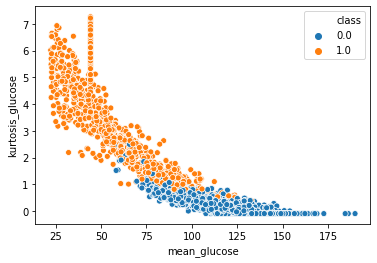

In [38]:
sns.scatterplot(data.mean_glucose, data.kurtosis_glucose, hue=data['class'])

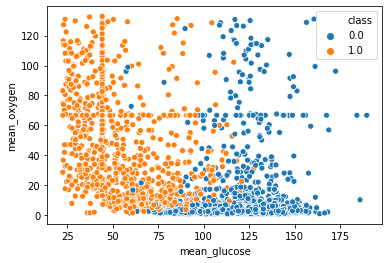

In [39]:
sns.scatterplot(data.mean_glucose, data.mean_oxygen, hue=data['class'])

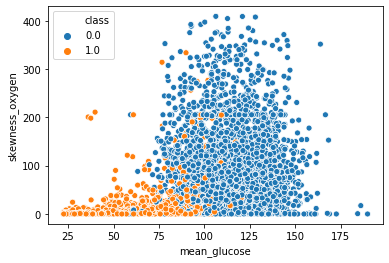

In [40]:
sns.scatterplot(data.mean_glucose, data.skewness_oxygen, hue=data['class'])

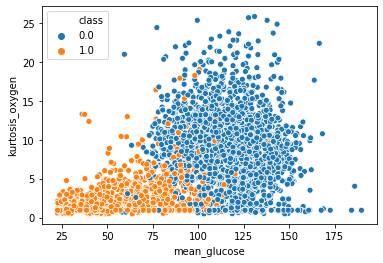

In [41]:
sns.scatterplot(data.mean_glucose, data.kurtosis_oxygen, hue=data['class'])

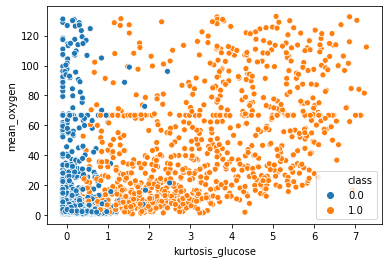

In [42]:
sns.scatterplot(data.kurtosis_glucose, data.mean_oxygen, hue=data['class'])

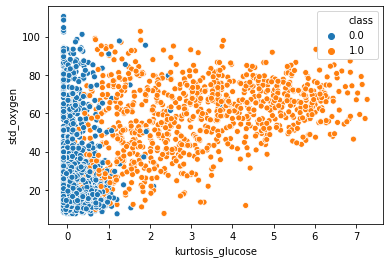

In [43]:
sns.scatterplot(data.kurtosis_glucose, data.std_oxygen, hue=data['class'])

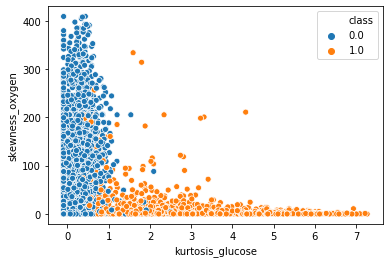

In [44]:
sns.scatterplot(data.kurtosis_glucose, data.skewness_oxygen, hue=data['class'])

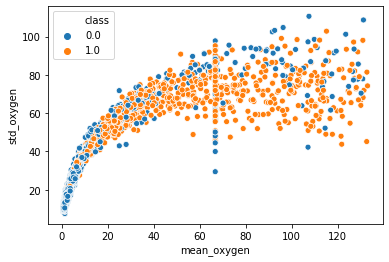

In [45]:
sns.scatterplot(data.mean_oxygen, data.std_oxygen, hue=data['class'])

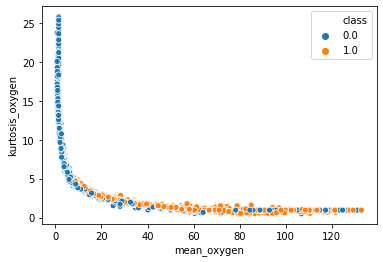

In [46]:
sns.scatterplot(data.mean_oxygen, data.kurtosis_oxygen, hue=data['class'])

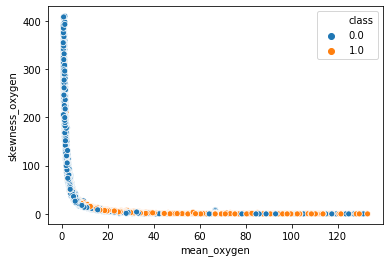

In [47]:
sns.scatterplot(data.mean_oxygen, data.skewness_oxygen, hue=data['class'])

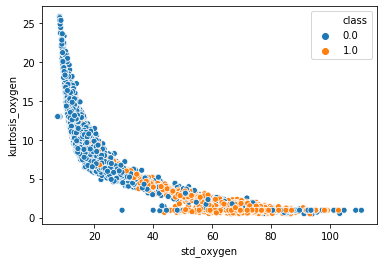

In [48]:
sns.scatterplot(data.std_oxygen, data.kurtosis_oxygen, hue=data['class'])

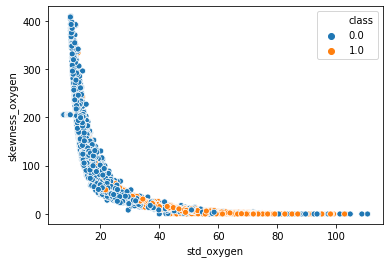

In [49]:
sns.scatterplot(data.std_oxygen, data.skewness_oxygen, hue=data['class'])

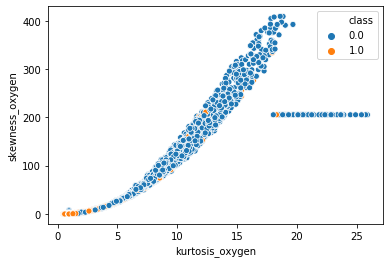

In [50]:
sns.scatterplot(data.kurtosis_oxygen, data.skewness_oxygen, hue=data['class'])

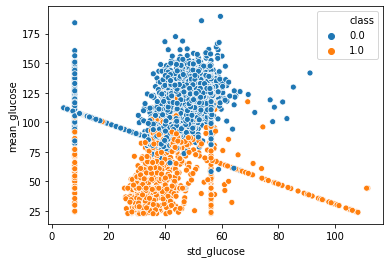

In [51]:
sns.scatterplot(data.std_glucose, data.mean_glucose, hue=data['class'])

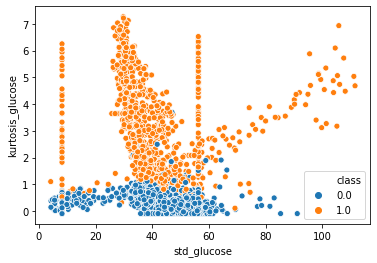

In [52]:
sns.scatterplot(data.std_glucose, data.kurtosis_glucose, hue=data['class'])

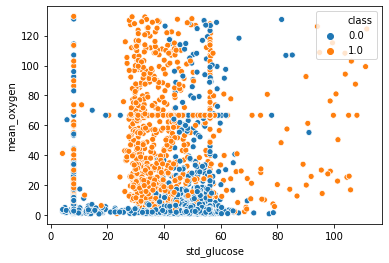

In [53]:
sns.scatterplot(data.std_glucose, data.mean_oxygen, hue=data['class'])

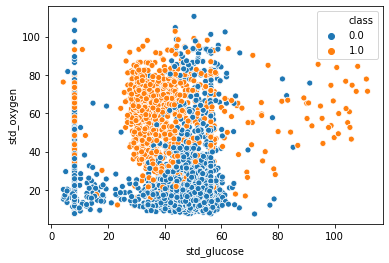

In [54]:
sns.scatterplot(data.std_glucose, data.std_oxygen, hue=data['class'])

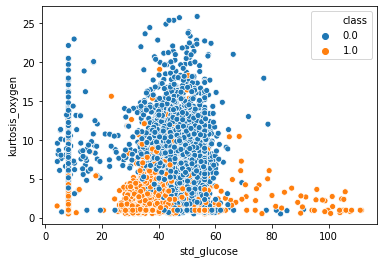

In [55]:
sns.scatterplot(data.std_glucose, data.kurtosis_oxygen, hue=data['class'])

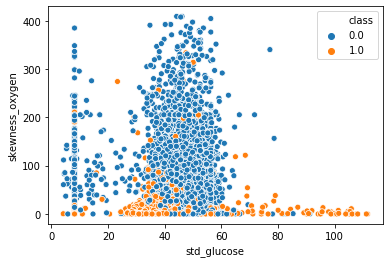

In [56]:
sns.scatterplot(data.std_glucose, data.skewness_oxygen, hue=data['class'])

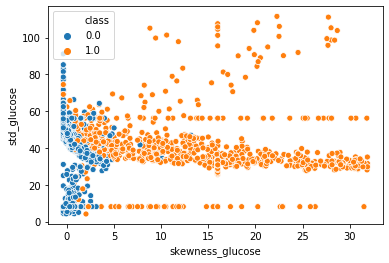

In [57]:
sns.scatterplot(data.skewness_glucose, data.std_glucose, hue=data['class'])

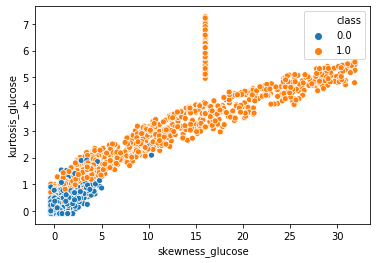

In [58]:
sns.scatterplot(data.skewness_glucose, data.kurtosis_glucose, hue=data['class'])

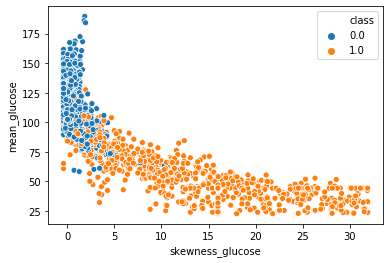

In [59]:
sns.scatterplot(data.skewness_glucose, data.mean_glucose, hue=data['class'])

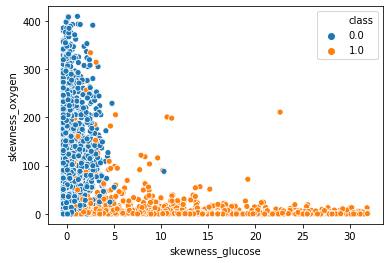

In [60]:
sns.scatterplot(data.skewness_glucose, data.skewness_oxygen, hue=data['class'])

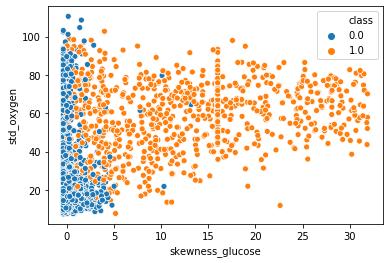

In [61]:
sns.scatterplot(data.skewness_glucose, data.std_oxygen, hue=data['class'])

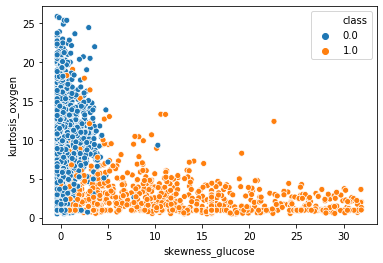

In [62]:
sns.scatterplot(data.skewness_glucose, data.kurtosis_oxygen, hue=data['class'])

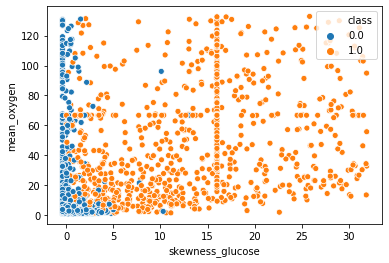

In [63]:
sns.scatterplot(data.skewness_glucose, data.mean_oxygen, hue=data['class'])

In [64]:
'''
    Manual classification of a row of data
'''
def manually_classify(line):
    if line[1]['mean_glucose'] < 55:
        return 1
    if line[1]['kurtosis_glucose'] > 2.2:
        return 1            
    if line[1]['mean_glucose'] < 85:
        if line[1]['kurtosis_oxygen'] < 6:
            return 1
        elif line[1]['skewness_glucose'] > 7.2:
            return 1
        return 0 
    elif line[1]['age'] > 76:
        return 1
    return 0

In [65]:
'''
    Tests the manual classification system on the given data set.
'''
def test_manual_classification(data, title):
    print('Testing manual classification on '+title+' data')
    positive = 0
    negative = 0
    correctCounter = 0
    falsePositive = 0
    falseNegative = 0
    for line in data.iterrows():
        if line[1]['class'] == 1:
            positive += 1
        else:
            negative += 1
        clr = manually_classify(line)
        if clr == line[1]['class']:
            correctCounter += 1
        else:
            if clr:
                falsePositive += 1
            else:
                falseNegative += 1
    print("Positive: ", positive)
    print("Negative: ", negative)
    print("False Positive: ",falsePositive)
    print("False Negative: ",falseNegative)
    print("Accuracy: ", (correctCounter / (correctCounter + falsePositive + falseNegative)) * 100, "%")
    print("Recall: ", (positive / (positive + falseNegative)) * 100, "%")
    print("Precision: ", (positive / (positive + falsePositive)) * 100, "%",end='\n\n')

In [66]:
# Test the manual classification on both train and real data
test_manual_classification(data,'train')
test_manual_classification(rdata,'real')   

Testing manual classification on train data
Positive:  1004
Negative:  2929
False Positive:  27
False Negative:  213
Accuracy:  93.8977879481312 %
Recall:  82.49794576828266 %
Precision:  97.3811833171678 %

Testing manual classification on real data
Positive:  347
Negative:  966
False Positive:  11
False Negative:  60
Accuracy:  94.5925361766946 %
Recall:  85.25798525798525 %
Precision:  96.92737430167597 %



In [67]:
rows = []
for row in data.iterrows():
    rows.append(row[1])

In [68]:
def class_counts(rows):
    counts = {} 
    for row in rows:
        label = row['class']
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [69]:
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [70]:
class Question:
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value
               

In [71]:
def partition(rows, question):
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [72]:
def gini(rows):
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [73]:
def info_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [74]:
def find_best_split(rows):
    
    best_gain = 0 
    best_question = None
    current_uncertainty = gini(rows)
    n_features = len(rdata.columns) 

    for col in range(n_features): 

        if rows[0][col] == rows[0]['class']:
            continue
        values = set([row[col] for row in rows])

        for val in values:

            question = Question(col, val)

            true_rows, false_rows = partition(rows, question)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [75]:
def find_best_values(rows):
    best_gain = 0 
    best_question = None
    current_uncertainty = gini(rows)
    n_features = len(rdata.columns) 
    bestVal = 0
    values = []

    for col in range(n_features): 
        best_gain = 0
        if data.dtypes[col] == 'object':
            continue
        if rows[0][col] == rows[0]['class']:
            continue
        values = set([row[col] for row in rows])

        for val in values:

            question = Question(col, val)

            true_rows, false_rows = partition(rows, question)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            gain = info_gain(true_rows, false_rows, current_uncertainty)

            if gain >= best_gain:
                bestVal = val
        print(type(bestVal))
        print(col, "   ", bestVal)
       
    return values

In [76]:
#find_best_values(rows)

In [77]:
values = [0,0,0,113,0,0,3982.0,0,0,0,0,16,0,0.003438096,130.3828125,0,0.353256495,0,40955.0,0,51.95196662,0,0,99.0,0,0,3.887123746,16.05407336,7.203474403,3.363576455,0]

In [78]:
def find_best_split_with_defined_value(rows):
    current_uncertainty = gini(rows)
    best_gain = 0
    n_features = len(rdata.columns)
    for col in range(n_features):
        if values[col] == 0:
            continue
        
        question = Question(col, values[col])

        true_rows, false_rows = partition(rows, question)
        
        if len(true_rows) == 0 or len(false_rows) == 0:
                continue

        gain = info_gain(true_rows, false_rows, current_uncertainty)

        if gain >= best_gain:
            best_gain, best_question = gain, question
            
    print(best_gain, best_question)
    return best_gain, best_question

In [79]:
class Leaf:
    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [80]:
class Decision_Node:
    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [81]:
def build_tree(rows):
    gain, question = find_best_split_with_defined_value(rows)

    if gain < 0.05:
        return Leaf(rows)

    true_rows, false_rows = partition(rows, question)

    true_branch = build_tree(true_rows)

    false_branch = build_tree(false_rows)

    return Decision_Node(question, true_branch, false_branch)

In [82]:
def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    print (spacing + str(node.question))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [83]:
my_tree = build_tree(rows)

0.1359187862587995 <__main__.Question object at 0x00000250B8CCB748>
0.2609851048245328 <__main__.Question object at 0x00000250B8CCB788>
0.02019110946231243 <__main__.Question object at 0x00000250B8CCB7C8>
0.0034293646260052657 <__main__.Question object at 0x00000250B8CCB648>
0.0009198842760616208 <__main__.Question object at 0x00000250B8CCB7C8>


In [84]:
print_tree(my_tree)

--> True:
  --> True:
    Predict {0.0: 175, 1.0: 899}
  --> False:
    Predict {0.0: 667, 1.0: 76}
--> False:
  Predict {0.0: 2087, 1.0: 29}


In [85]:
def classify(row, node):
    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [86]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [87]:
validRows = []
for row in rdata.iterrows():
    validRows.append(row[1])

In [88]:
for row in validRows:
    print ("Actual: %s. Predicted: %s" %
           (row['class'], print_leaf(classify(row, my_tree))))

Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '

Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '

Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 1.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '1

Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '89%', 1.0: '10%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 0.0. Predicted: {0.0: '98%', 1.0: '1%'}
Actual: 1.0. Predicted: {0.0: '16%', 1.0: '83%'}
Actual: 0.0. Predicted: {0.0: '98

# Documentation


## Applied code changes for being able to apply the pre-processing process to the real data

1. Loaded the real data after loading the train data
    (**rdata** = loaded `personal_valid.csv`, **rdata2** = loaded `other_valid.csv`)


2. Changed method **`fix_data`** to accept the personal and the other real data as arguments as well


3. The following operations have been applied without any changes to the real data as well, not only to the train data:
    - **`rename_id_column`**`(rdata, rdata2, debug)`
    - **`extract_medical_info`**`(rdata, rdata2, debug)`
    - **`fix_date_of_birth`**`(rdata, rdata2, debug)`
    - **`fix_non_numeric_age_values`**`(rdata, rdata2, debug)`
    - **`fix_date_format`**`(rdata, rdata2, debug)`
    - **`calc_missing_ages_from_date_of_birth`**`(rdata, rdata2, debug)`
    - **`trim_leading_spaces`**`(rdata, rdata2, debug)`
    - **`merge_duplicate_rows`**`(rdata, rdata2, debug)`
    - **`fix_pregnant`**`(rdata, rdata2, debug)`


4. For calculating the missing data using **linear regression** we needed to pass other both train and
   other real data to the `replace_missing_data_with_regr` method.
   
   We needed to change it so it only does the **linear regression** model fitting / training with the train data,
   while applying all the missing data filling to both train data and real data.
   
5. We needed to apply a similar change to the `replace_missing_data_with_medians` as well.
   After passing the real data to it together with the training one we needed to calculate the median using the train
   data only, while applying all the required missing data filling with **median** to both train data and real data

6. We fully removed the `replace_outlying_log` method since after testing it at the pre-processing state,
   we realized that using the `replace_outlying_0595` method instead is giving us better results.
   
7. We have found some issues in the `replace_outlying_0595` method, which caused it giving us some way too big
   and some even negative metric values for both **training** and **real** data, so we needed to fine tune it
   by setting it, so it replaces every numeric columns every value at both **train** and **real** data to
   the **90%** percentil of the training data set, if it was greater than **2** times that calculated **90%**
   percentil value.
   
   Of course we needed to change the lower bound as well, so we replaced every numeric columns every value at both
   **train** and **real** data to the **10%** percentil of the training data set, if it was greater than **0.5** times
   that calculated **90%** percentil value.
   
   For being able to realize those changes of course we needed to pass both **train** and **real** data to this method as an argument.
  
8. The last change we needed to do was at merging. We needed to do merging between train personal and train
   other data, as well as between real personal and real other data.
   
   For being able to do that more accurately, than previously, we did it according to both **`name`** and **`address`** column now.


## Manual classification

For being able to do manual classification we needed to plot out the chart of each metrics related to the classification of the train data.

Based on those charts and after doing some intensive testing and fine tuning we managed to achieve the following testing results:

**Train data:**
- **Positive:**  1004
- **Negative:**  2929
- **False Positive:**  27
- **False Negative:**  213
- **Accuracy:**  93.8977879481312 %
- **Recall:**  82.49794576828266 %
- **Precision:**  97.3811833171678 %

**Real data:**
- **Positive:**  347
- **Negative:**  966
- **False Positive:**  11
- **False Negative:**  60
- **Accuracy:**  94.5925361766946 %
- **Recall:**  85.25798525798525 %
- **Precision:**  96.92737430167597 %

The manual classification tester method is the **`test_manual_classification`**`(data, title)`

The manual classifactor method is the **`manually_classify`**`(line)`

## Using DecisionTrees

With customized decision trees we were able to reach an improvement in all the metrics we made (accuracy, recall and precision).

The results we got from them were the following:

**TODO:** Add results

Since finding the best multiplier for each column takes a lot of time, we have included the result numbers in the
code and commented out the calculation process. That way we will be able to run the program much faster.


- **Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov (4b).** s využítím funkcii:
- **` partition(rows, question) `**
- **` gini(rows) `**
- **` find_best_values(rows) `**
- **` find_best_split_with_defined_value(rows) `**
- **` build_tree(rows) `**
- **` classify(row, node) `**

1. V datasete program najskôr vyhľadá pre každý atribút najvhodnejšiu hranicu rozdelovania pomocou funkcie **` find_best_values `**

2. z týchto hraníc vyberie tú, ktorá v danom bode dokáže najlepšie rozdeliť dataset

3. Dataset sa rozdelí podľa zvoleného atribútu a hodnoty.

4. Pomocou funkcie **` info_gain `** zistí čistotu dát v danej množine. Pokiaľ spĺňa zadanú hodnotu, pokračuje v bode 5. pokiaľ nespĺňa hodnotu tak sa daná množina vráti do bodu 1

5. Vetva sa pridá do stromu

6. Funkcia **` classify `** využije pravidlá z naučeného stromu a aplikuje ich na nový dataset
- **Optimalizácia hyperparametrov (4b).** Preskúmajte hyperparametre klasifikačného algoritmu `CART` a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali preučenie. Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite 10-násobnú krížovú validáciu na trénovacej množine.

## Conclusion


- **Vyhodnotenie vplyvu zvolenej stratégie riešenia chýbajúcich hodnôt na správnosť klasifikácie (2b).** Zistite, či použitie zvolených stratégií riešenia chýbajúcich hodnôt vplýva na správnosť (angl. accuracy) klasifikácie. Ktorá stratégia sa ukázala ako vhodnejšia pre daný problém?
